      dt  switch  pktcount  bytecount  dur   dur_nsec       tot_dur  flows  \
0  27588       1        68       6664   71   56000000  7.105600e+10      5   
1  33333       2       154      15092  158  296000000  1.580000e+11     11   
2   9876       2     19494   20780604   42  894000000  4.289400e+10      3   
3   2638       1     88695   94548870  197   19000000  1.970000e+11      3   
4  28488       1       947      92806  971  134000000  9.710000e+11      5   

   packetins  pktperflow  ...  dst_10.0.0.4  dst_10.0.0.5  dst_10.0.0.6  \
0       2790          29  ...             0             0             0   
1       3024          29  ...             0             0             0   
2       1910       13527  ...             0             0             0   
3       2375       13529  ...             0             0             0   
4       2800          29  ...             0             0             0   

   dst_10.0.0.7  dst_10.0.0.8  dst_10.0.0.9  Protocol_ICMP  Protocol_TCP  \
0   

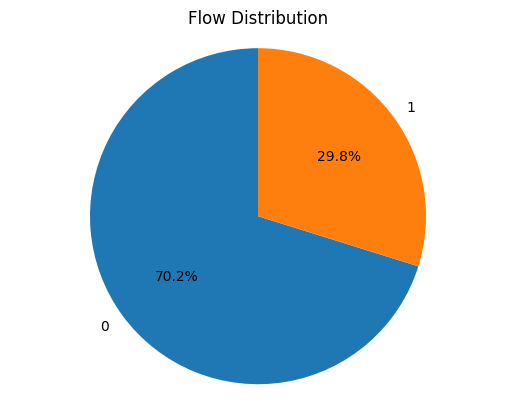

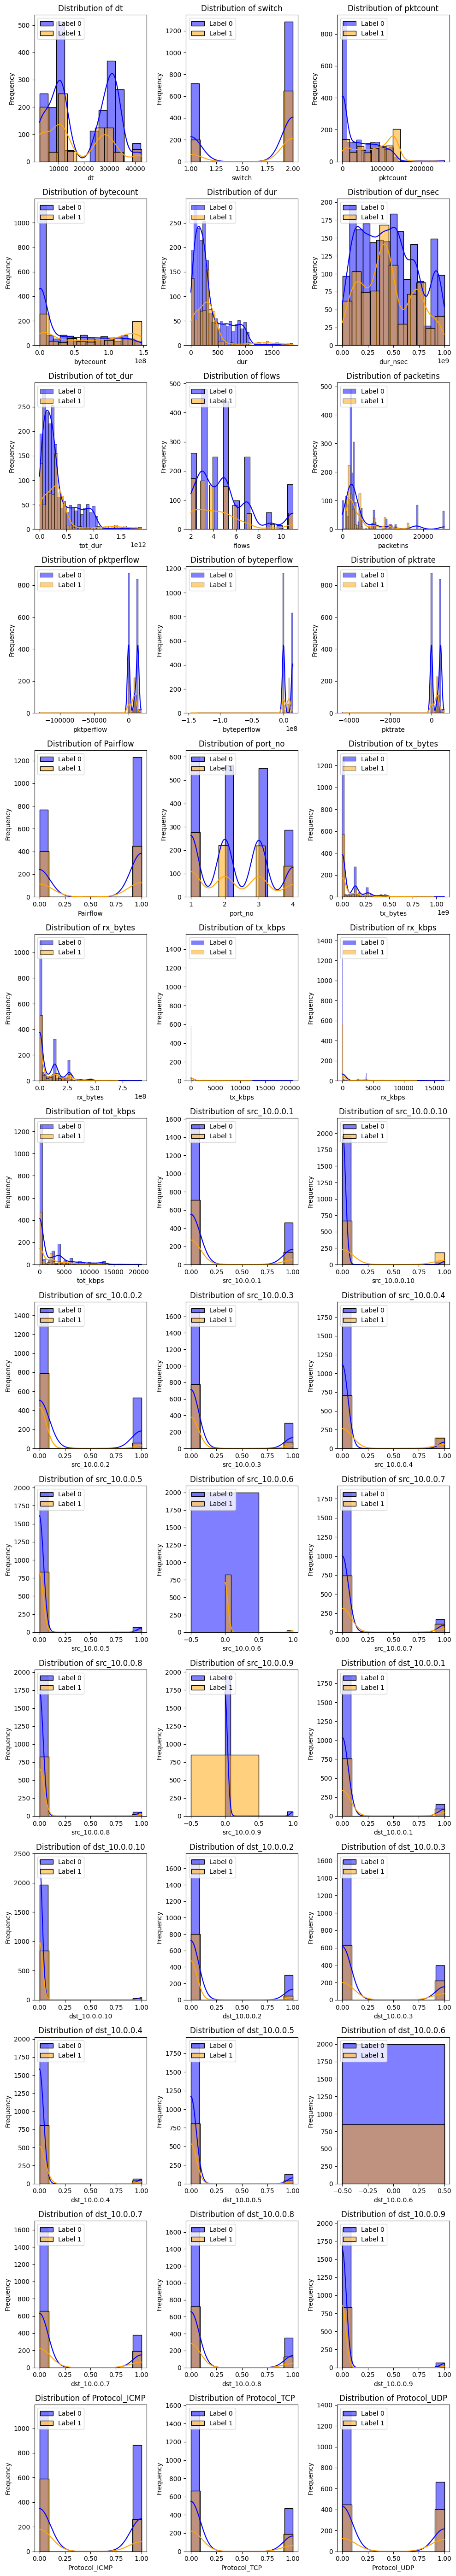

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


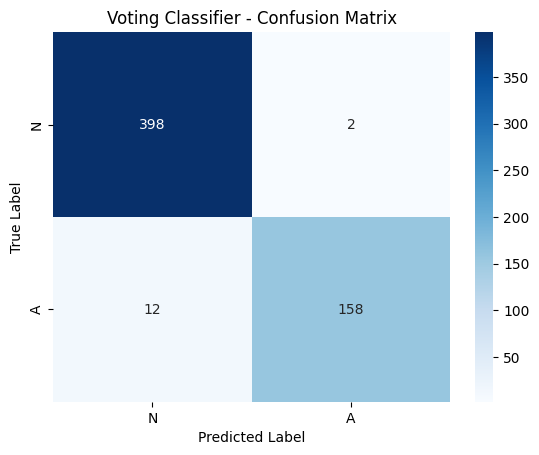

Voting Classifier Performance:
Validation - F1 Score: 0.9735, Precision: 0.9880, Recall: 0.9593, Accuracy: 0.9842
Test - F1 Score: 0.9576, Precision: 0.9875, Recall: 0.9294, Accuracy: 0.9754


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


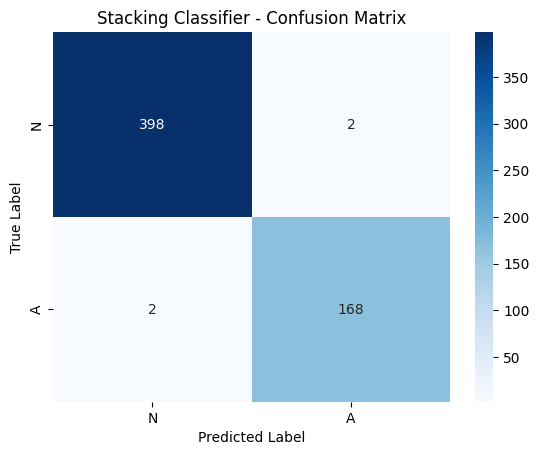

Stacking Model Performance:
Validation - F1 Score: 0.9825, Precision: 0.9882, Recall: 0.9767, Accuracy: 0.9895
Test - F1 Score: 0.9882, Precision: 0.9882, Recall: 0.9882, Accuracy: 0.9930


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer

# Veri kümesini yükleme
df = pd.read_csv("/content/drive/MyDrive/Colab çalışma/yeni proje/SDN_Dataset_openflow.csv")

# Veri kümesini inceleme
print(df.head())
print(df.info())

# Etiket dağılımının görselleştirilmesi
flow_counts = df["label"].value_counts()
plt.pie(flow_counts, labels=flow_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Flow Distribution")
plt.show()

def plot_feature_distributions(df, label_column, n_cols=3):
    feature_names = df.columns[:-1]
    n_rows = (len(feature_names) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

    for i, feature in enumerate(feature_names):
        row, col = divmod(i, n_cols)
        sns.histplot(df[df[label_column] == 0][feature], label='Label 0', kde=True, color='blue', ax=axes[row, col])
        sns.histplot(df[df[label_column] == 1][feature], label='Label 1', kde=True, color='orange', ax=axes[row, col])
        axes[row, col].set_title(f'Distribution of {feature}')
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].legend(loc='upper left')

    for i in range(len(feature_names), n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

# Özellik dağılımlarını çiz
plot_feature_distributions(df.copy(), label_column="label")

X = df.iloc[:, :-1]
y = df['label']

# Veriyi bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Eksik değerleri doldurma
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Özellikleri ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Sınıflandırıcıları tanımlama
nb_classifier = BernoulliNB()
#PA_classifier = PassiveAggressiveClassifier(max_iter=1000, random_state=42)
mlp_classifier = MLPClassifier(random_state=42)
dt_classifier = DecisionTreeClassifier(random_state=42)
xgb_classifier = xgb.XGBClassifier(random_state=42)

# VotingClassifier
voting_classifier = VotingClassifier(estimators=[
    ('nb', nb_classifier),
    ('mlp', mlp_classifier),
    ('dt', dt_classifier),
    ('xgb', xgb_classifier)
], voting='hard')

# VotingClassifier'ı eğit
voting_classifier.fit(X_train_scaled, y_train)

# VotingClassifier'ı değerlendir
y_pred_val = voting_classifier.predict(X_val_scaled)
y_pred_test = voting_classifier.predict(X_test_scaled)

f1_val = f1_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

# Karışıklık Matrisi görselleştirme
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["N", "A"], yticklabels=["N", "A"])
plt.title('Voting Classifier - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Performansı yazdırma
print("Voting Classifier Performance:")
print(f"Validation - F1 Score: {f1_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, Accuracy: {accuracy_val:.4f}")
print(f"Test - F1 Score: {f1_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, Accuracy: {accuracy_test:.4f}")

# Online Stacking
stage1_train_preds = pd.DataFrame()
stage1_val_preds = pd.DataFrame()
stage1_test_preds = pd.DataFrame()

#, ('pa', PA_classifier)
for name, model in [('nb', nb_classifier) , ('mlp', mlp_classifier),
                    ('dt', dt_classifier), ('xgb', xgb_classifier)]:
    model.fit(X_train_scaled, y_train)
    stage1_train_preds[name] = model.predict(X_train_scaled)
    stage1_val_preds[name] = model.predict(X_val_scaled)
    stage1_test_preds[name] = model.predict(X_test_scaled)

stacking_model = LogisticRegression(random_state=42)
stacking_model.fit(stage1_train_preds, y_train)

y_pred_val_stack = stacking_model.predict(stage1_val_preds)
y_pred_test_stack = stacking_model.predict(stage1_test_preds)

f1_val_stack = f1_score(y_val, y_pred_val_stack)
precision_val_stack = precision_score(y_val, y_pred_val_stack)
recall_val_stack = recall_score(y_val, y_pred_val_stack)
accuracy_val_stack = accuracy_score(y_val, y_pred_val_stack)

f1_test_stack = f1_score(y_test, y_pred_test_stack)
precision_test_stack = precision_score(y_test, y_pred_test_stack)
recall_test_stack = recall_score(y_test, y_pred_test_stack)
accuracy_test_stack = accuracy_score(y_test, y_pred_test_stack)
cm_test_stack = confusion_matrix(y_test, y_pred_test_stack)

sns.heatmap(cm_test_stack, annot=True, fmt="d", cmap="Blues", xticklabels=["N", "A"], yticklabels=["N", "A"])
plt.title('Stacking Classifier - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Stacking Model Performance:")
print(f"Validation - F1 Score: {f1_val_stack:.4f}, Precision: {precision_val_stack:.4f}, Recall: {recall_val_stack:.4f}, Accuracy: {accuracy_val_stack:.4f}")
print(f"Test - F1 Score: {f1_test_stack:.4f}, Precision: {precision_test_stack:.4f}, Recall: {recall_test_stack:.4f}, Accuracy: {accuracy_test_stack:.4f}")
